<a href="https://colab.research.google.com/github/qmeng222/MNIST-Playground/blob/main/more-on-data/noise_augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Task:
*   Oversampling wo/ being exactly redundant
*   Use noise augmentation to prevent overfitting ("data regularization")

Method:
*   Double training samples with white noise added
*   Test set is really independent
*   Training set, devset, test set

In [77]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

In [78]:
# import dataset (comes with colab!)
dataFull = np.loadtxt(open('sample_data/mnist_train_small.csv','rb'),delimiter=',')
print(type(dataFull))
print(dataFull.shape)
print(dataFull)

<class 'numpy.ndarray'>
(20000, 785)
[[6. 0. 0. ... 0. 0. 0.]
 [5. 0. 0. ... 0. 0. 0.]
 [7. 0. 0. ... 0. 0. 0.]
 ...
 [2. 0. 0. ... 0. 0. 0.]
 [9. 0. 0. ... 0. 0. 0.]
 [5. 0. 0. ... 0. 0. 0.]]


👆 20000 numbers, 785 = 28^2 + 1 (28 pixels x 28 pixels, 1 label)

In [79]:
# normalize the data to [0 1]:
dataFull[:,1:] = dataFull[:,1:] / np.max(dataFull)

def makeTheDataset(N,doubleTheData=False): # N: sample size

  # get data and labels with the right sample size:
  data   = dataFull[:N,1:]
  labels = dataFull[:N,0]

  # # (NOT RECOMMENDED) make a noisy copy of ALL data (train & test):
  # if doubleTheData:
  #   dataN  = data + np.random.random_sample(data.shape)/2 # enerates random numbers (0~.5) from a uniform distribution
  #   dataN = dataN / torch.max(dataN) # re-normalize to [0, 1]
  #   data   = np.concatenate((data,dataN),axis=0) # normalized pixel values (0~1) now may exceed 1
  #   labels = np.concatenate((labels,labels),axis=0)

  # np array -> pytorch tensor:
  dataT   = torch.tensor( data   ).float()
  labelsT = torch.tensor( labels ).long()

  # use scikitlearn to split the data：
  train_data,devset_data, train_labels,devset_labels = train_test_split(dataT, labelsT, train_size=.9) # still pytorch tensors
  print("training_data size:", train_data.shape)
  print("training_label size:", train_labels.shape)
  print("dev_data size:", devset_data.shape)
  print("dev_label size:", devset_labels.shape)

  # (after splitting) make a noisy copy of the TRAIN data only:
  if doubleTheData:
    train_dataN  = train_data + torch.rand_like(train_data)/2 # add noise to tensor, now prev normalized pixel values may exceed 1
    train_dataN = train_dataN / torch.max(train_dataN)
    train_data   = torch.cat((train_data,train_dataN),axis=0)
    train_labels = torch.cat((train_labels,train_labels),axis=0)

  # pytorch tensor ->  pytorch dataset obj (combine):
  train_data  = TensorDataset(train_data,train_labels)
  devset_data = TensorDataset(devset_data,devset_labels)

  # pytorch dataset obj -> pytorch dataloader obj:
  batchsize     = 20
  train_loader  = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
  devset_loader = DataLoader(devset_data,batch_size=devset_data.tensors[0].shape[0])

  # NEW!! Create an UNSEEN test set in tensors (don't need a dataloader):
  testdata   = torch.tensor( dataFull[N:,1:] ).float()
  testlabels = torch.tensor( dataFull[N:,0]  ).long()

  return train_loader,devset_loader,(testdata,testlabels)

training_data size: torch.Size([10, 784])
training_label size: torch.Size([10])
dev_data size: torch.Size([2, 784])
dev_label size: torch.Size([2])


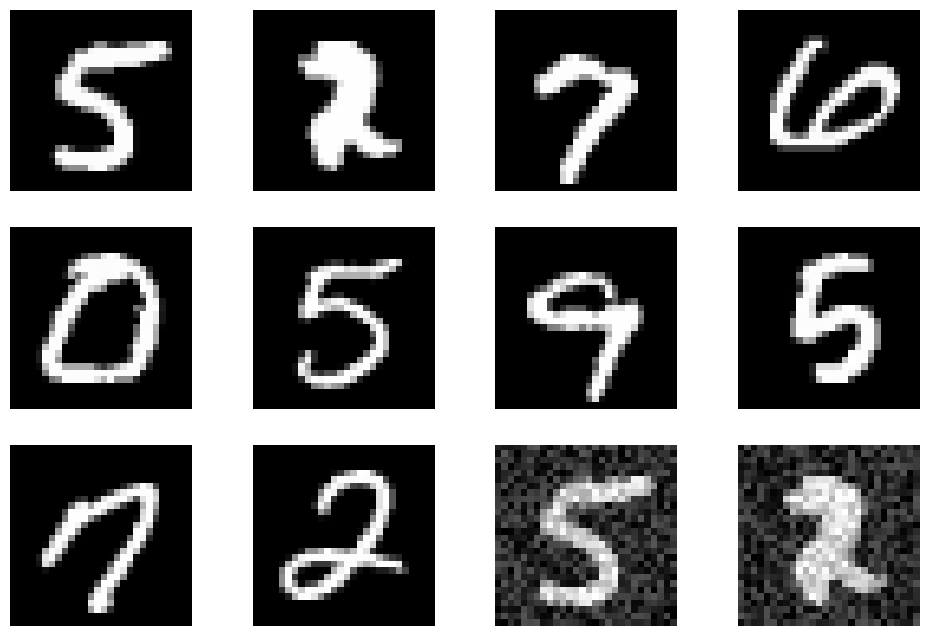

In [80]:
train_loader,devset_loader,testdataset = makeTheDataset(12,True) # testdataset duple: (testdata,testlabels)

# create a new tensor by disconnecting the tensor from its previous history
# so as to perform independent operations on the new tensor wo/ affecting or being affected by the gradient updates from backprop
img = train_loader.dataset.tensors[0].detach()
fig,ax = plt.subplots(3,4,figsize=(12,8))
for i,ax in enumerate(ax.flatten()):
  ax.imshow(np.reshape(img[i,:],(28,28)) ,cmap='gray')
  ax.axis('off')
plt.show()

In [81]:
# create a class for the model
def createTheMNISTNet():

  class mnistNet(nn.Module):
    def __init__(self):
      super().__init__()

      ### input layer
      self.input = nn.Linear(784,64)

      ### hidden layer
      self.fc1 = nn.Linear(64,32)
      self.fc2 = nn.Linear(32,32)

      ### output layer
      self.output = nn.Linear(32,10)

    # forward pass
    def forward(self,x):
      x = F.relu( self.input(x) )
      x = F.relu( self.fc1(x) )
      x = F.relu( self.fc2(x) )
      return self.output(x)

  # create the model instance
  net = mnistNet()

  # loss function
  lossfun = nn.CrossEntropyLoss()

  # optimizer
  optimizer = torch.optim.SGD(net.parameters(),lr=.01)

  return net,lossfun,optimizer

In [82]:
# a function that trains the model

def function2trainTheModel():

  # number of epochs
  numepochs = 50

  # create a new model
  net,lossfun,optimizer = createTheMNISTNet()

  # initialize losses
  losses    = torch.zeros(numepochs)
  trainAcc  = []
  devsetAcc = []


  # loop over epochs
  for epochi in range(numepochs):

    # loop over training data batches
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())

      # compute accuracy
      matches = torch.argmax(yHat,axis=1) == y     # booleans (false/true)
      matchesNumeric = matches.float()             # convert to numbers (0/1)
      accuracyPct = 100*torch.mean(matchesNumeric) # average and x100
      batchAcc.append( accuracyPct )               # add to list of accuracies
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # and get average losses across the batches
    losses[epochi] = np.mean(batchLoss)

    # devset accuracy
    X,y = next(iter(devset_loader)) # extract X,y from devset dataloader
    with torch.no_grad(): # deactivates autograd
      yHat = net(X)

    # compare the following really long line of code to the training accuracy lines
    devsetAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1)==y).float()) )

  # end epochs

  # function output
  return trainAcc,devsetAcc,losses,net

In [83]:
# takes ~3 mins

# list of data sample sizes
samplesizes = np.arange(500,4001,500) # sample sizes: 500~4000 in step size of 500

# initialize results matrix
resultsSingle = np.zeros((len(samplesizes),3))
resultsDouble = np.zeros((len(samplesizes),3))

for idx,ssize in enumerate(samplesizes):


  ### 1. without doubling the data (doubleTheData=False):
  # generate a dataset and train the model
  train_loader,devset_loader,testdataset = makeTheDataset(ssize,False)
  trainAcc,devsetAcc,losses,net = function2trainTheModel()

  # grab the results
  resultsSingle[idx,0] = np.mean(trainAcc[-5:])
  resultsSingle[idx,1] = np.mean(devsetAcc[-5:])
  resultsSingle[idx,2] = torch.mean(losses[-5:]).item()


  ### 2. with doubling the data (doubleTheData=True):
  # generate a dataset and train the model
  train_loader,devset_loader,testdataset = makeTheDataset(ssize,True)
  trainAcc,devsetAcc,losses,net          = function2trainTheModel()

  # grab the results
  resultsDouble[idx,0] = np.mean(trainAcc[-5:])
  resultsDouble[idx,1] = np.mean(devsetAcc[-5:])
  resultsDouble[idx,2] = torch.mean(losses[-5:]).item()

training_data size: torch.Size([450, 784])
training_label size: torch.Size([450])
dev_data size: torch.Size([50, 784])
dev_label size: torch.Size([50])
training_data size: torch.Size([450, 784])
training_label size: torch.Size([450])
dev_data size: torch.Size([50, 784])
dev_label size: torch.Size([50])
training_data size: torch.Size([900, 784])
training_label size: torch.Size([900])
dev_data size: torch.Size([100, 784])
dev_label size: torch.Size([100])
training_data size: torch.Size([900, 784])
training_label size: torch.Size([900])
dev_data size: torch.Size([100, 784])
dev_label size: torch.Size([100])
training_data size: torch.Size([1350, 784])
training_label size: torch.Size([1350])
dev_data size: torch.Size([150, 784])
dev_label size: torch.Size([150])
training_data size: torch.Size([1350, 784])
training_label size: torch.Size([1350])
dev_data size: torch.Size([150, 784])
dev_label size: torch.Size([150])
training_data size: torch.Size([1800, 784])
training_label size: torch.Size(

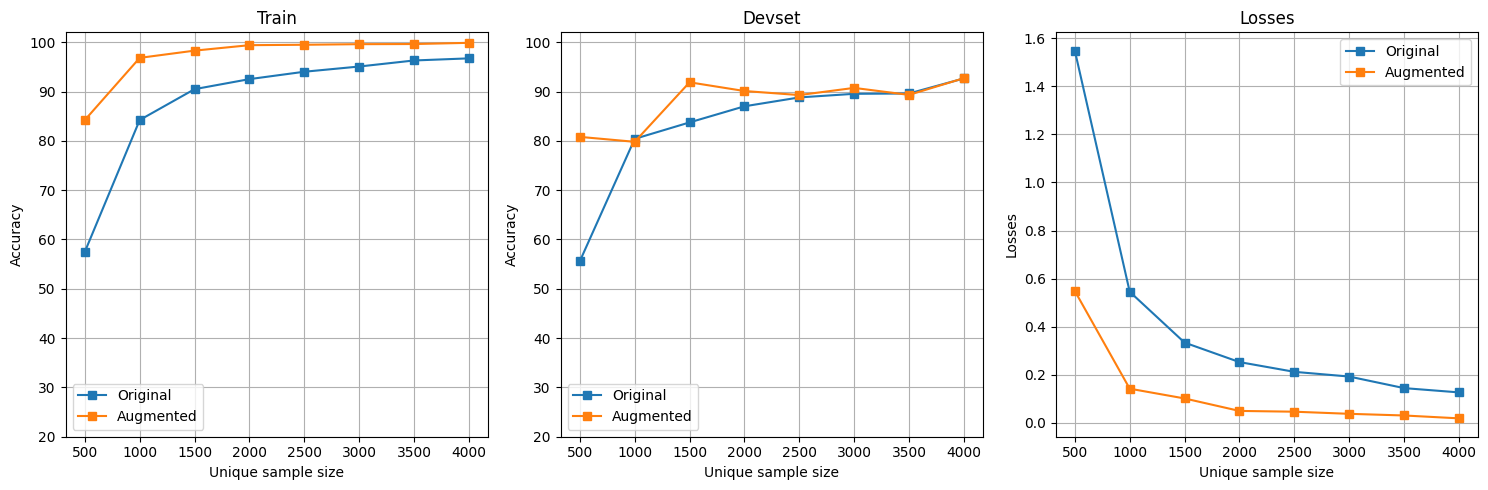

In [84]:
# visualize the results:

fig,ax = plt.subplots(1,3,figsize=(15,5))

# axis and title labels
titles    = ['Train','Devset','Losses']
yaxlabels = ['Accuracy','Accuracy','Losses']

# common features
for i in range(3):

  # plot the lines
  ax[i].plot(samplesizes,resultsSingle[:,i],'s-',label='Original')
  ax[i].plot(samplesizes,resultsDouble[:,i],'s-',label='Augmented')

  # make it look nicer
  ax[i].set_ylabel(yaxlabels[i])
  ax[i].set_title(titles[i])
  ax[i].legend()
  ax[i].set_xlabel('Unique sample size')
  ax[i].grid('on')

  if i<2:
    ax[i].set_ylim([20,102])

plt.tight_layout()
plt.show()

In [85]:
# re-run the models for N=500

samplesize = 500

# original:
train_loader,devset_loader,testdataset  = makeTheDataset(samplesize,False)
trainAccO,devsetAccO,lossesO,netO       = function2trainTheModel() # O = original

# augmented:
train_loader,devset_loader,testdataset  = makeTheDataset(samplesize,True)
trainAccA,devsetAccA,lossesA,netA       = function2trainTheModel() # A = augmented

training_data size: torch.Size([450, 784])
training_label size: torch.Size([450])
dev_data size: torch.Size([50, 784])
dev_label size: torch.Size([50])
training_data size: torch.Size([450, 784])
training_label size: torch.Size([450])
dev_data size: torch.Size([50, 784])
dev_label size: torch.Size([50])


In [86]:
# Now for the real test! On the test data!

# extract the test data
X,y = testdataset # (data, label) duple

# run the original model
yHat = netO(X)
testO = 100*torch.mean((torch.argmax(yHat,axis=1)==y).float())

# And the augmented model
yHat = netA(X)
testA = 100*torch.mean((torch.argmax(yHat,axis=1)==y).float())

# print the results!
print( f'ORIGINAL MODEL (N={samplesize}):\n  Train: {trainAccO[-1]:.2f}%, devset: {devsetAccO[-1]:.2f}%, test: {testO:.2f}%\n\n')
print(f'AUGMENTED MODEL (N={samplesize}):\n  Train: {trainAccA[-1]:.2f}%, devset: {devsetAccA[-1]:.2f}%, test: {testA:.2f}%')

ORIGINAL MODEL (N=500):
  Train: 33.64%, devset: 16.00%, test: 26.33%


AUGMENTED MODEL (N=500):
  Train: 85.11%, devset: 84.00%, test: 77.67%


**Observations:**

---
*   It looks like noise augmentation only helped for small sample sizes (less than 1000).
*   Noise augmenttation helps with generalization because the model is less able to memorize specific samples.